<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [3]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy


## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [4]:
##### Your Code Here #####
df = pd.read_csv('./data/job_listings.csv')
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


## 2) Use Spacy to tokenize / clean the listings 

In [9]:
##### Your Code Here #####
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__(convert_charrefs=False)
        self.reset()
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def handle_entityref(self, name):
        self.fed.append('&%s;' % name)

    def handle_charref(self, name):
        self.fed.append('&#%s;' % name)

    def get_data(self):
        return ''.join(self.fed)


def _strip_once(value):
    s = MLStripper()
    s.feed(value)
    s.close()
    return s.get_data()
def strip_tags(value):
    """Return the given HTML with all tags stripped."""
    # Note: in typical case this loop executes _strip_once once. Loop condition
    # is redundant, but helps to reduce number of executions of _strip_once.
    value = str(value)
    while '<' in value and '>' in value:
        new_value = _strip_once(value)
        if value.count('<') == new_value.count('<'):
            # _strip_once wasn't able to detect more tags.
            break
        value = new_value
    return value

In [10]:
df['description'] = df['description'].apply(strip_tags)

In [11]:
nlp = spacy.load("en_core_web_lg")
def tokenize(text):
    doc =nlp(text)
    return [token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [8]:
df['tokens'] = df['description'].apply(tokenize)

In [12]:
import re
df['description'] = df['description'].apply(lambda x: re.sub(r'\\x..', '', x))

In [13]:
df.shape

(426, 4)

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [14]:
##### Your Code Here #####

vect = CountVectorizer(stop_words='english', analyzer='word')
vect.fit(df['description'])

sparse_dtm = vect.transform((df['description']))

dtm = pd.DataFrame(sparse_dtm.todense(), columns=vect.get_feature_names())

In [15]:
dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zero,zeus,zf,zfs,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
dtm.sum().sort_values(ascending=False).head()

data          4394
experience    1238
business      1198
work           978
team           958
dtype: int64

## 4) Visualize the most common word counts

Text(0.5, 1.0, 'Top 10 words')

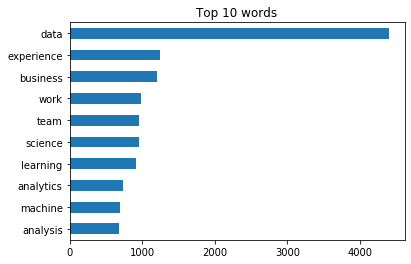

In [144]:
##### Your Code Here #####
dtm.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot.barh()
plt.title('Top 10 words')

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [17]:
##### Your Code Here #####
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english')

# Create a vocabulary and get word counts per document
sparse = tfidf.fit_transform(df['description'])

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()


,00,000,02115,03,0356,04,062,06366,08,10,...,zero,zeus,zf,zfs,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.104418,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [18]:
##### Your Code Here #####
# Instantiate
from sklearn.neighbors import NearestNeighbors


# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)


NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [19]:
description = '''
Python Data Engineer

Work on a team to build products using data science,
'''

In [20]:
new = tfidf.transform([description])

nn.kneighbors(new.todense())

(array([[1.19869598, 1.19905483, 1.19905483, 1.20629532, 1.22432133]]),
 array([[217,  33, 378, 261, 216]]))

In [21]:
#matching description
df.description[217]

"b'Senior Business Intelligence Data Engineer\\nRocky Hill, CT\\n\\n\\n\\nJob Description\\n\\nOverview\\nAxians redtoo recently brought its almost 30 years of experience in IT and consulting solutions to the Axians family. As both strategic advisors and a full-service IT provider, our customers\\' core businesses benefit through our optimization of their business processes and effectively implementing their technology investment.\\n\\nWe are seeking Senior Business Intelligence Data Engineer to join our client.\\n\\nPosition Overview\\nOur client is looking for an awesome Data/Business Intelligence Engineer to join our growing team of Data warehouse. The hire will be responsible for expanding and optimizing our data and data pipeline architecture, as well as optimizing data flow and collection for cross functional teams. The ideal candidate is an experienced data pipeline builder and data wrangler who enjoys optimizing data systems and building them from the ground up.\\n\\nThe person

In [22]:
from urllib.parse import urlencode
from requests_html import HTMLSession
from multiprocessing.dummy import Pool
from itertools import chain

class IndeedJobListings:
    '''
    Multi-theaded Indeed Job Listings Crawler
    Usage:
    listings = IndeedJobListings('Data Scientist', 'Seattle, WA')
    descriptions = listings.get_descriptions(pages=10)
    '''
    def __init__(self, search_keyword, location, threads=12):
        self.threads = threads
        self.base_url = 'https://www.indeed.com'
        self.query_url = f'{self.base_url}/jobs?' +\
        urlencode({'q': search_keyword, 'l': location})
        self.session = HTMLSession()
    
    def _get_posting_urls(self, url):
        doc = self.session.get(url)
        posting_urls = [f'{self.base_url}{e.attrs["href"]}' for e in doc.html.find('.jobtitle.turnstileLink')]
        return posting_urls

    def _get_description_text(self, url):
        doc = self.session.get(url)
        description_text = doc.html.find('#jobDescriptionText')[0].text
        return description_text
                        
    def get_descriptions(self, pages=1):
        list_urls = [self.query_url] + [f'{self.query_url}&start={x*10}'
                                        for x in range(1, pages)]
        p = Pool(self.threads)
        post_urls = chain(*p.map(self._get_posting_urls, list_urls))
        descriptions = p.map(self._get_description_text, post_urls)
        return descriptions


listings = IndeedJobListings('Data Scientist', 'Seattle, WA')
descriptions = listings.get_descriptions(pages=1)

In [23]:
descriptions

['Summary\nPosted: Feb 7, 2019\nWeekly Hours: 40\nRole Number: 200020558\nWe are searching for engineers with a real passion for using machine learning to build intelligent applications. In this highly accomplished, deeply technical and close-knit team of data scientists and machine learning engineers, you will craft tools that are used by millions of people. You will have a chance to design and implement new machine learning algorithms and techniques and collaborate with the most innovative product development teams in the world. Our team researches new machine learning algorithms, models and techniques that will power amazingly intelligent user experiences. We are looking for new ambitious members to join our research ML group. In this role, you will design new models and algorithms, and actively engage with the academic community by publishing your work and participating in academic efforts. You will also have the opportunity to contribute to every cool project around Apple, and use

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 